# Inleiding

Dit is een notebook om een aantal routines te controleren die benodigd zijn voor het werken met golfspectra (geavanceerde methode) 

In [1]:
import timeit

In [2]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

UsageError: Line magic function `%` not found.


JONSWAP

In [3]:
def jonswap(f, Hm0, Tp, gamma=3.3, sigma_low=.07, sigma_high=.09, g=9.81, method='yamaguchi', normalize=False):
        """
        Generate JONSWAP spectrum

        Parameters
        ----------
        Hm0 : float
            Required zeroth order moment wave height
        Tp : float
            Required peak wave period
        gamma : float
            JONSWAP peak-enhancement factor (default: 3.3)
        sigma_low : float
            Sigma value for frequencies <= ``1/Tp`` (default: 0.07)
        sigma_high : float
            Sigma value for frequencies > ``1/Tp`` (default: 0.09)
        g : float
            Gravitational constant (default: 9.81)
        method : str
            Method to compute alpha (default: yamaguchi)
        normalize : bool
            Normalize resulting spectrum to match ``Hm0``
    
        Returns
        -------
        E : numpy.ndarray
            Array of shape ``f`` with wave energy densities 
    
        """

        # Pierson-Moskowitz
        if method.lower() == 'yamaguchi':
            alpha = 1. / (.06533 * gamma ** .8015 + .13467) / 16.
        elif method.lower() == 'goda':
            alpha = 1. / (.23 + .03 * gamma - .185 / (1.9 + gamma)) / 16.
        else:
            raise ValueError('Unknown method: {}'.format(method))
            
        # TODO radialen per seconde
        # E_pm(f) = alpha_pm * g^2 (2pi)^-4 f^-5 exp(-(5/4) * (f/f_PM)^-4 )
        E_pm = alpha * Hm0 ** 2 * Tp ** -4 * f ** -5 * np.exp(-1.25 * (Tp * f) ** -4)
        
        # JONSWAP
        sigma = np.ones(f.shape) * sigma_low
        sigma[f > 1. / Tp] = sigma_high

        E_js = E_pm * gamma ** np.exp(-0.5 * (Tp * f - 1) ** 2. / sigma ** 2.)
    
        if normalize:
            E_js *= Hm0 ** 2. / (16. * np.trapz(E_js, f))
        
        return E_js

In [4]:
def jonswap_2d(f, theta, S_1d, Hm0, Tp, Theta, spread, g=9.81, test=False):
        """
        Calculates a 2d JONSWAP spectral density

        Parameters
        ----------
        S_1d : numpy.ndarray
            Array with 1d wave energy densities 
        Hm0 : float
            Required zeroth order moment wave height
        Tp : float
            Required peak wave period
        Theta : float
            mean wave direction [deg] w.r.t. North
        spread : float
            Determines the spreading [-]
        g : float
            Gravitational constant (default: 9.81)
        test : bool
            Whether to check the resulting wave height with the input waveheight

        Returns
        -------
        s2d : numpy.ndarray
            the spectral density
        """
        
        # peak frequency
        fp = 1.0 / Tp
    
        # Determine the stepsize in the directions
        dtheta = np.deg2rad(np.diff(theta[:2])[0])
        bins = np.deg2rad(theta % 360)
        theta0 = np.deg2rad(Theta % 360)

        nf = len(f)
        nd = len(theta)

        # If the spread is not given, compute it
        if spread is None:
            # deep water wave steepness
            steepness = Hm0 / (g * Tp ** 2. / (2. * np.pi))
            # computation of parameter smax
            steepness_points = [0, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 1.0]
            smax_points = [160, 160, 70, 35, 20, 7, 2.001, 2.0]
            # Interpolate linear
            smax = np.interp(steepness, steepness_points, smax_points)
            # Calculate spread for all frequencies
            power = np.ones_like(f) * -2.5
            power[f <= fp] = 5.0
            spread = (f / fp) ** (power * smax)

        # If given as input, create array of the number
        else:
            spread = np.ones_like(f) * spread
            
        # Convert to range -np.pi to np.pi relative to the mean wave direction
        Az = ( ((bins - theta0) + np.pi) % (2 * np.pi) - np.pi ) / 2
        
        # computation of G0 (Equation 2.23) for all frequencies
        G0 = 1 / np.sum(np.cos(Az[:, np.newaxis]) ** (2 * spread[np.newaxis, :]), axis=0)
        
        # If the direction is (smaller than half pi) AND (larger than minus half pi), so
        # if the direction is from the 'right' half of the circle
        G = G0[:, np.newaxis] * np.cos(Az[np.newaxis, :]) ** (2.0 * spread[:, np.newaxis]) / dtheta
        S_2d = S_1d[:, np.newaxis] * G
                
        # If it is from the other side of the spectrum
        S_2d[:, np.abs(Az) > np.pi / 2.0] = 0.

        if test:
            # Multiply each energy density bin width its area and sum. Calculate wave height from this
            Hm0_1D_test = 4 * np.sqrt(np.trapz(S_1d, f))
            Hm0_2D_test = 4 * np.sqrt(np.trapz(S_2d.sum(axis=1) * dtheta, f).sum())

            print('Input Hm0: {:.5f} m\nJONSWAP 1D Hm0: {:.5f} m\nJONSWAP 2D Hm0: {:.5f} m'.format(
                Hm0, Hm0_1D_test, Hm0_2D_test
            ))
        

        return S_2d

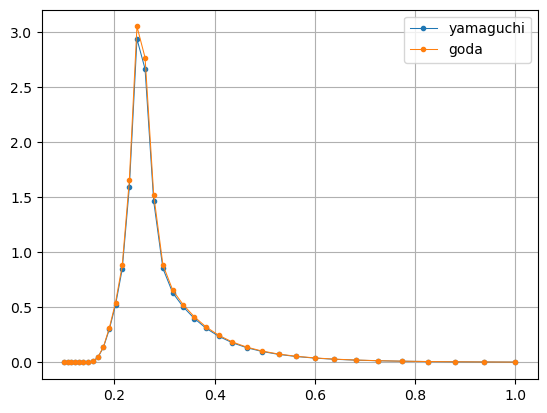

In [5]:
frequencies = np.logspace(np.log10(0.1), np.log10(1.0), 37)
# frequencies = np.linspace(0.1, 1.0, 101)
Tp = 4.0
Hm0 = 2.0
E_js1 = jonswap(frequencies, Hm0, Tp, method='yamaguchi')
E_js2 = jonswap(frequencies, Hm0, Tp, method='goda')

fig, ax = plt.subplots()
ax.plot(frequencies, E_js1, label='yamaguchi', lw=0.75, marker='.' )
ax.plot(frequencies, E_js2, label='goda', lw=0.75, marker='.' )
ax.legend()
ax.grid()

In [6]:
print(4 * np.sqrt(np.sum(E_js1 * np.diff(frequencies[:2]))))

1.2221865928206306


In [7]:
directions = np.arange(0, 360, 5)
# S_2d = spread_jonswap_2d2(f=frequencies, theta=directions, S_1d=E_js, Hm0=4.0, Tp=2.0, Theta=90, spread=10)
print(0.028)
S_2d = jonswap_2d(f=frequencies, theta=directions, S_1d=E_js1, Hm0=Hm0, Tp=Tp, Theta=250, spread=10, test=True)

0.028
Input Hm0: 2.00000 m
JONSWAP 1D Hm0: 1.99880 m
JONSWAP 2D Hm0: 1.99880 m


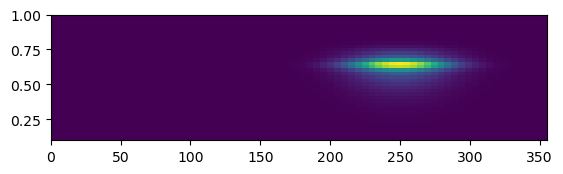

In [8]:
plt.imshow(
    S_2d,
    extent=(
        directions.min(),
        directions.max(),
        frequencies.min(),
        frequencies.max()
    ),
    aspect=100
)

# TP,smooth

14
3.9909269693162712
0.25056835359012364


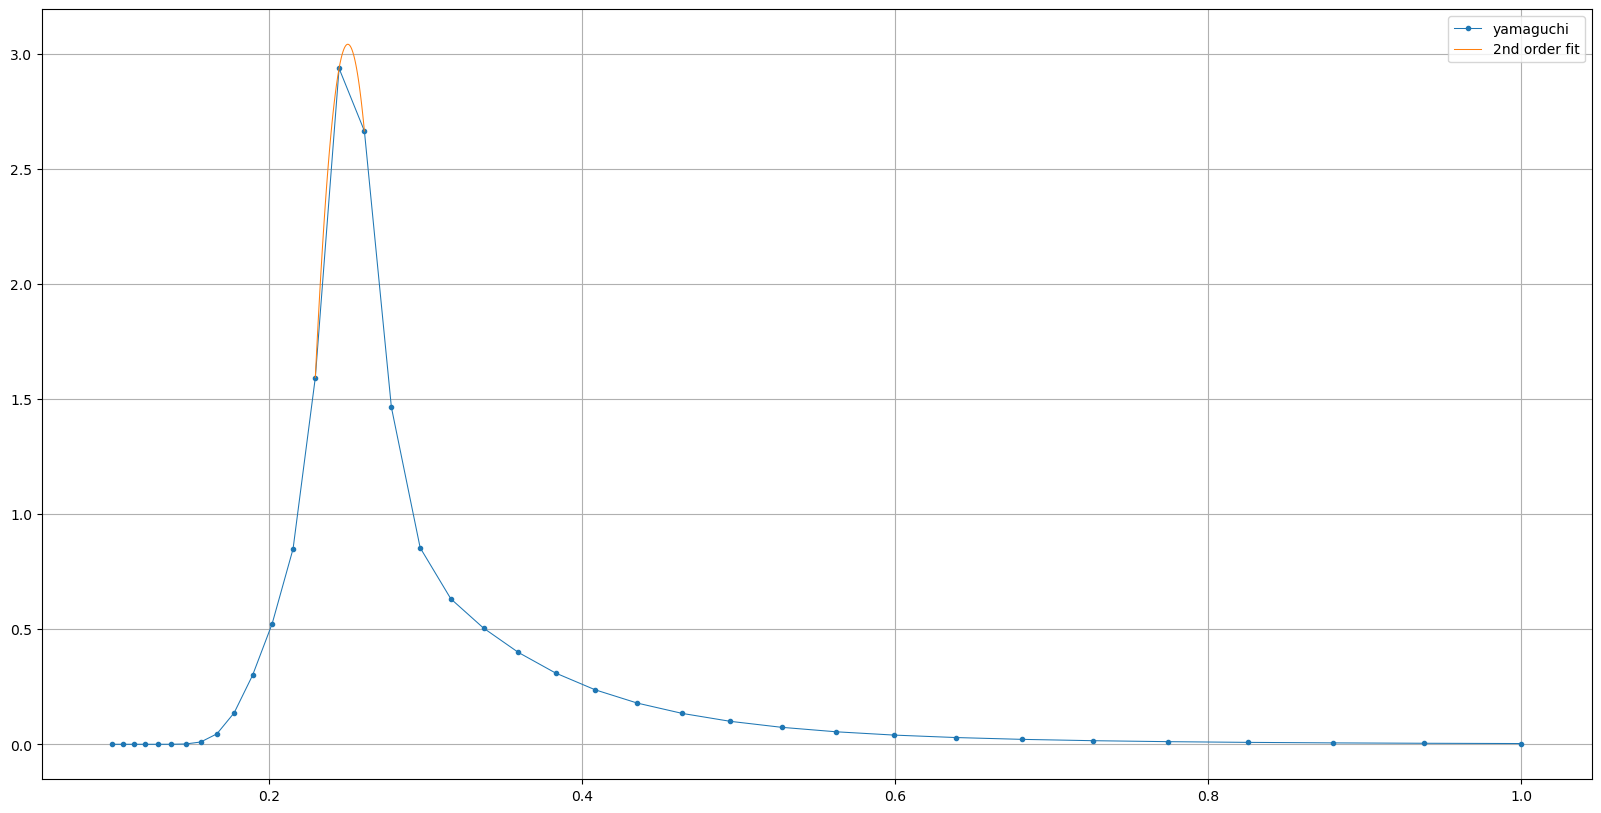

In [9]:
E_js = jonswap(frequencies, Hm0, Tp, method='yamaguchi')
imax = np.argmax(E_js)
print(imax)
fgrid = np.linspace(frequencies[imax - 1], frequencies[imax + 1], 100)
y = np.polyval(np.polyfit(frequencies[imax-1:imax+2], E_js[imax-1:imax+2], 2), fgrid)

print(1./ fgrid[np.argmax(y)])
print(fgrid[np.argmax(y)].max())

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(frequencies, E_js, label='yamaguchi', lw=0.75, marker='.' )
ax.plot(fgrid, y, label='2nd order fit', lw=0.75)
ax.legend()
ax.grid()

In [10]:
1./frequencies[np.argmax(E_js)]

4.084238652674522

In [11]:
np.argmax(S_2d, axis=0)

array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  0, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14], dtype=int64)

In [12]:
def Tp_smooth(energy, f):
    """
    Calculate the peak period with a fit 
    """

    Tp_smooth = np.zeros(np.size(energy, axis=1))
    fp_local = np.zeros(np.size(energy, axis=3))
    Ep_local = np.zeros_like(fp_local)

    # 1/ the frequency where the energy per direction is largest.
    for ilocatie, spectrum in enumerate(energy[0]):
        # Determine frequencies with highest energy per direction
        imaxs = np.argmax(spectrum, axis=0)
        
        # For each direction
        for j, (imax, energy_per_f) in enumerate(zip(imaxs, spectrum.T)):
            # If the peak highest frequency is found on the edges, dont fit
            if imax == 0 or imax == len(energy_per_f)-1:
                fp_local[j] = f[imax]

            # Else, polyfit the peak
            else:
                # Create a parabolic fit trough the top 3 points
                p = np.polyfit(f[imax - 1:imax + 2], energy_per_f[imax - 1:imax + 2], 2)
                fgrid = np.linspace(f[imax - 1], f[imax + 1], 100)
                Epfit = np.polyval(p, fgrid)

                # Save the max energy and the frequency at the max
                Ep_local[j] = Epfit.max()
                fp_local[j] = fgrid[Epfit.argmax()]
                
        # Take the peak period at the maximum energy density
        Tp_smooth[ilocatie] = 1 / fp_local[np.argmax(Ep_local)]

    return Tp_smooth

In [13]:
energy = np.stack([S_2d] * 10)
energy = energy[np.newaxis, :, :, :]
energy.shape

(1, 10, 37, 72)

In [14]:
st = timeit.default_timer()
print(Tp_smooth(energy, frequencies))
print(timeit.default_timer() - st)

[3.99092697 3.99092697 3.99092697 3.99092697 3.99092697 3.99092697
 3.99092697 3.99092697 3.99092697 3.99092697]
0.06093250005505979


In [15]:
def calc_parabola_vertex(x, y):
        '''
        Adapted and modifed to get the unknowns for defining a parabola:
        http://stackoverflow.com/questions/717762/how-to-calculate-the-vertex-of-a-parabola-given-three-points
        '''
        x1, x2, x3 = x
        y1, y2, y3 = y
        denom = (x1-x2) * (x1-x3) * (x2-x3)
        A = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
        B = (x3**2 * (y1-y2) + x2**2 * (y3-y1) + x1**2 * (y2-y3)) / denom
        C = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom

        return A, B, C

def Tp_smooth(energy, f):
    """
    Calculate the peak period with a fit 
    """
    nt, nxy, nf, nd = np.shape(energy)
    
    Tp_smooth = np.zeros(nxy)
    fp_local = np.zeros(nd)
    Ep_local = np.zeros(nd)

    # 1/ the frequency where the energy per direction is largest.
    for ilocatie, spectrum in enumerate(energy[0]):
        # Determine frequencies with highest energy per direction
        imaxs = np.argmax(spectrum, axis=0)
        
        # Determine which directions need to be fitted
        fit_indices = np.ones(nd, dtype=bool)
        fit_indices[(imaxs == 0) + (imaxs == (nf-1))] = False

        # Determine the frequencies to pick
        f_ind = np.hstack([np.arange(imax-1, imax+2) for imax in imaxs[fit_indices]])
        # Determine the directions to pick
        d_ind = np.repeat(np.arange(len(fit_indices))[fit_indices], 3)
        # Pick frequencies and energies, and reshape for fitting
        frequencies = f[f_ind].reshape(3, sum(fit_indices), order='F')
        energies = spectrum.T[d_ind, f_ind].reshape(3, sum(fit_indices), order='F')
        
        # Create a parabola trough the top 3 points
        A, B, C = calc_parabola_vertex(
            x=frequencies,
            y=energies
        )
        # Calculate the max frequency by calculating f'(x) = 0 : x = -B/(2A)
        fmax = -B / (2 * A)
        # Calculate energy
        Ep_local[fit_indices] = A * fmax ** 2 + B * fmax + C
        fp_local[fit_indices] = fmax
        
        # Take the peak period at the maximum energy density
        Tp_smooth[ilocatie] = 1 / fp_local[np.argmax(Ep_local)]

    return Tp_smooth

In [16]:
st = timeit.default_timer()
print(Tp_smooth(energy, frequencies))
print(timeit.default_timer() - st)

[3.99317415 3.99317415 3.99317415 3.99317415 3.99317415 3.99317415
 3.99317415 3.99317415 3.99317415 3.99317415]
0.002675600000657141


In [17]:
p = np.poly1d([1,1,1,1])
p2 = np.polyder(p)

In [18]:
a = np.arange(20).reshape((4, 5))
a[[0, 3, 2, 1, 0, 0], [2, 3, 2, 2, 3, 3]]

array([ 2, 18, 12,  7,  3,  3])

In [19]:
def calc_optimum(f, E):
    # Create a parabolic fit trough the top 3 points
    A, B, C = calc_parabola_vertex(f, E)
    f_max = -B / (2 * A)
    E_max = A * f_max ** 2 + B * f_max + C

    return E_max, f_max


def Tp_smooth(energy, f):
    """
    Calculate the peak period with a fit 
    """

    Tp_smooth = np.zeros(np.size(energy, axis=1))
    fp_local = np.zeros(np.size(energy, axis=3))
    Ep_local = np.zeros_like(fp_local)

    # 1/ the frequency where the energy per direction is largest.
    for ilocatie, spectrum in enumerate(energy[0]):
        # Determine frequencies with highest energy per direction
        imaxs = np.argmax(spectrum, axis=0)
        
        # For each direction
        for j, (imax, energy_per_f) in enumerate(zip(imaxs, spectrum.T)):
            # If the peak highest frequency is found on the edges, dont fit
            if imax == 0 or imax == len(energy_per_f)-1:
                fp_local[j] = f[imax]
                Ep_local[j] = energy_per_f[imax]

            # Else, polyfit the peak
            else:
                # Save the max energy and the frequency at the max
                Ep_local[j], fp_local[j] = calc_optimum(f[imax - 1:imax + 2], energy_per_f[imax - 1:imax + 2])

                
        # Take the peak period at the maximum energy density
        Tp_smooth[ilocatie] = 1 / fp_local[np.argmax(Ep_local)]

    return Tp_smooth

In [20]:
st = timeit.default_timer()
print(Tp_smooth(energy, frequencies))
print(timeit.default_timer() - st)

[3.99317415 3.99317415 3.99317415 3.99317415 3.99317415 3.99317415
 3.99317415 3.99317415 3.99317415 3.99317415]
0.004948300076648593
